# CelebA Dataset

*Note that the outputs of model training cells were cleared, so that the jupyter notebook does note crash when opening in browser (this happened to me and I shit my pants)

## Imports

In [32]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import io
import shutil
import os
import PIL
from scipy import interpolate

## Helper Methods

In [2]:
def grid_plot(images, epoch='', name='', n=3, save=False, scale=False):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    if save:
        filename = 'results/generated_plot_e%03d_f.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()
    plt.show()
    
    
def grid_plot_tensorboard(images, epoch='', name='', n=3, scale=False):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    
    return fig
    
    
def build_conv_net(in_shape, out_shape, n_downsampling_layers=4, filters=128, out_activation='sigmoid'):
    """
    Build a basic convolutional network
    """
    model = tf.keras.Sequential()
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    model.add(Conv2D(input_shape=in_shape, **default_args, filters=filters))

    for _ in range(n_downsampling_layers):
        model.add(Conv2D(**default_args, filters=filters))

    model.add(Flatten())
    model.add(Dense(out_shape, activation=out_activation) )
    model.summary()
    return model


def build_deconv_net(latent_dim, n_upsampling_layers=4, filters=128, activation_out='sigmoid'):
    """
    Build a deconvolutional network for decoding/upscaling latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that
    were used in the downsampling network and the Conv2DTranspose layers are used instead of Conv2D layers.
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    shape of our input images.
    """

    model = tf.keras.Sequential()
    model.add(Dense(4 * 4 * 64, input_dim=latent_dim))
    model.add(Reshape((4, 4, 64))) # This matches the output size of the downsampling architecture
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    for i in range(n_upsampling_layers):
        model.add(Conv2DTranspose(**default_args, filters=filters))

    # This last convolutional layer converts back to 3 channel RGB image
    model.add(Conv2D(filters=3, kernel_size=(3,3), activation=activation_out, padding='same'))
    model.summary()
    return model


class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon


def build_vae(data_shape, latent_dim, filters=128):

    # Building the encoder - starts with a simple downsampling convolutional network
    encoder = build_conv_net(data_shape, latent_dim*2, filters=filters)

    # Adding special sampling layer that uses the reparametrization trick
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])

    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))

    # Adding the special loss term
    kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
    vae.add_loss(kl_loss/tf.cast(tf.keras.backend.prod(data_shape), tf.float32))

    vae.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3), loss='binary_crossentropy')

    return encoder, decoder, vae

In [3]:
def build_gan(data_shape, latent_dim, filters=128, lr=0.0002, beta_1=0.5):
    optimizer = tf.optimizers.legacy.Adam(learning_rate=lr, beta_1=beta_1)

    # Usually thew GAN generator has tanh activation function in the output layer
    generator = build_deconv_net(latent_dim, activation_out='tanh', filters=filters)

    # Build and compile the discriminator
    discriminator = build_conv_net(in_shape=data_shape, out_shape=1, filters=filters) # Single output for binary classification
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)

    # End-to-end GAN model for training the generator
    discriminator.trainable = False
    true_fake_prediction = discriminator(generator.output)
    GAN = tf.keras.Model(inputs=generator.input, outputs=true_fake_prediction)
    GAN = tf.keras.models.Sequential([generator, discriminator])
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer)

    return discriminator, generator, GAN


def run_generator(generator, n_samples=100):
    """
    Run the generator model and generate n samples of synthetic images using random latent vectors
    """
    latent_dim = generator.layers[0].input_shape[-1]
    generator_input = np.random.randn(n_samples, latent_dim)

    return generator.predict(generator_input)


def get_batch(generator, datagen):
    """
    Gets a single batch of samples (X) and labels (y) for the training the discriminator.
    One half from the real dataset (labeled as 1s), the other created by the generator model (labeled as 0s).
    """
    real_data = next(datagen)[0]
    fake_data = run_generator(generator, n_samples=len(real_data))

    X = np.concatenate([fake_data, real_data], axis=0)
    y = np.concatenate([np.zeros([len(fake_data), 1]), np.ones([len(real_data), 1])], axis=0)

    return X, y


def train_gan(generator, discriminator, gan, datagen, latent_dim, n_epochs=20, batch_size=128):
    for epoch in range(n_epochs):
        for batch in tqdm(range(len(datagen))):

            # 1) Train discriminator both on real and synthesized images
            X, y = get_batch(generator, datagen)
            discriminator_loss = discriminator.train_on_batch(X, y)

            # 2) Train generator (note that now the label of synthetic images is reversed to 1)
            X_gan = np.random.randn(batch_size * 2, latent_dim)
            y_gan = np.ones([batch_size * 2, 1])
            generator_loss = gan.train_on_batch(X_gan, y_gan)

        noise = np.random.randn(16, latent_dim)
        images = generator.predict(noise)
        grid_plot(images, epoch, name='GAN generated images', n=3, save=False, scale=True)

In [4]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image


def log_vae_generation(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    latent_vectors = np.random.randn(9, latent_dim)
    images = decoder(latent_vectors)
    figure = grid_plot_tensorboard(images, epoch, name=f'VAE generated images in epoch {epoch}', n=3)

    gen_image = plot_to_image(figure)

    with file_writer.as_default():
        tf.summary.image("Generated Images", gen_image, step=epoch)

In [54]:
def linear_interpolation(latent_dim, ts):
    latent_vectors = np.random.randn(2, latent_dim)
    latent_vector1, latent_vector2 = latent_vectors[0], latent_vectors[1]

    interpolated_vecs = []
    for t in ts:
        interpolated_vec = np.array([(1 - t) * v1 + t * v2 for v1, v2 in zip(latent_vector1, latent_vector2)])
        interpolated_vecs.append(interpolated_vec)
    
    return np.array(interpolated_vecs)

# Plot Original Data

*Note: move the downloaded dataset into a new folder called img_dataset

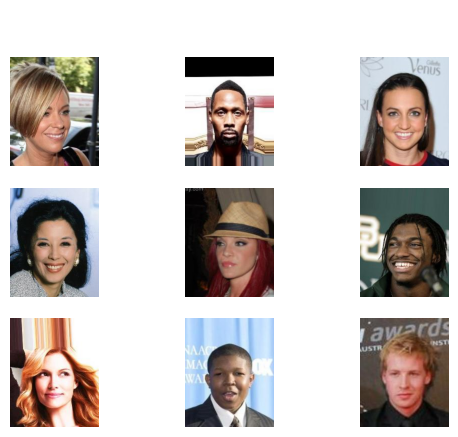

In [7]:
data_dir = "./img_dataset/"
imgs_dir = os.path.join(data_dir, "img_align_celeba")

display_imgs = []
for img_name in os.listdir(imgs_dir)[:9]:
    img_path = os.path.join(imgs_dir, img_name)
    display_imgs.append(PIL.Image.open(img_path))

grid_plot(display_imgs)

## Load New Data

In [5]:
data_dir = "./img_dataset/"
batch_size = 128

In [6]:
datagen = ImageDataGenerator(rescale=1./255)
data_generator = datagen.flow_from_directory(data_dir, target_size=(64, 64), batch_size=batch_size, class_mode="input")

Found 202599 images belonging to 1 classes.


## Load Limited Data

In [26]:
data_dir = "./img_dataset/"
limited_data_dir = "./limited_img_dataset/"
limited_data_count = 20000
batch_size = 128

copy_src_folder = f"{data_dir}/img_align_celeba/"
copy_dest_folder = f"{limited_data_dir}/img_align_celeba/"
os.makedirs(copy_dest_folder, exist_ok=True)

In [19]:
for img_name in os.listdir(copy_src_folder)[:limited_data_count]:
    src_img_path = os.path.join(copy_src_folder, img_name)
    dest_img_path = os.path.join(copy_dest_folder, img_name)
    shutil.copy(src_img_path, dest_img_path)

In [27]:
limited_datagen = ImageDataGenerator(rescale=1./255)
limited_data_generator = limited_datagen.flow_from_directory(limited_data_dir, target_size=(64, 64), batch_size=batch_size, class_mode="input")

Found 20000 images belonging to 1 classes.


# VAE Training

In [28]:
model_save_path = "models"
tensorboard_log_dir = "logs/fit"
epochs = 30

## Train on Full Data

### First Experiment

In [ ]:
latent_dim = 32
filters = 128
encoder, decoder, vae = build_vae((64, 64, 3), latent_dim, filters=filters)

log_dir = f"{tensorboard_log_dir}/vae_latent{latent_dim}_filter{filters}"
filepath = f"{model_save_path}/vae_latent{latent_dim}_filter{filters}"
file_writer = tf.summary.create_file_writer(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
grid_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_vae_generation)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_freq='epoch'
)

vae.fit_generator(data_generator, epochs=epochs, callbacks=[checkpoint_callback, tensorboard_callback, grid_callback])

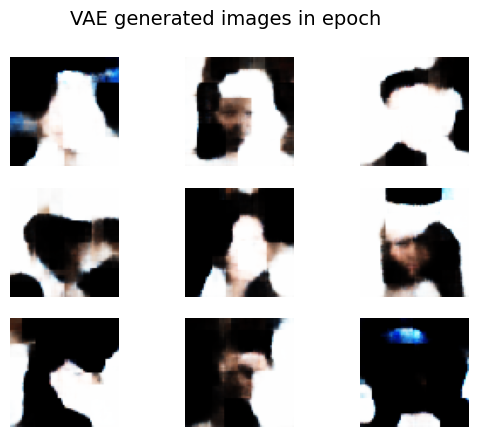

In [50]:
latent_vectors = np.random.randn(9, latent_dim)
images = decoder(latent_vectors)
grid_plot(images, epoch='', name=f'VAE generated images in epoch', n=3)

### Second Experiment

In [ ]:
latent_dim = 64
filters = 128
encoder, decoder, vae = build_vae((64, 64, 3), latent_dim, filters=filters)

log_dir = f"{tensorboard_log_dir}/vae_latent{latent_dim}_filter{filters}"
filepath = f"{model_save_path}/vae_latent{latent_dim}_filter{filters}"
file_writer = tf.summary.create_file_writer(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
grid_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_vae_generation)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_freq='epoch'
)

vae.fit_generator(data_generator, epochs=epochs, callbacks=[checkpoint_callback, tensorboard_callback, grid_callback])

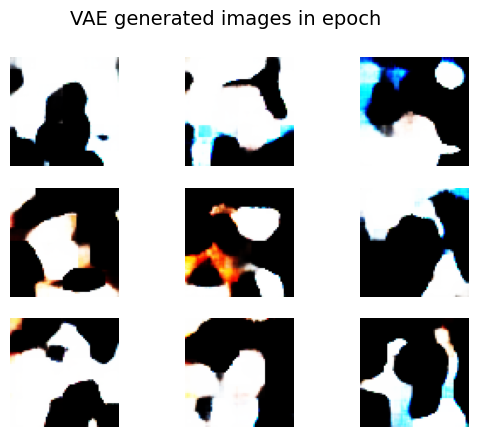

In [67]:
latent_vectors = np.random.randn(9, latent_dim)
images = decoder(latent_vectors)
grid_plot(images, epoch='', name=f'VAE generated images in epoch', n=3)

### Third Experiment

In [ ]:
latent_dim = 64
filters = 256
encoder, decoder, vae = build_vae((64, 64, 3), latent_dim, filters=filters)

log_dir = f"{tensorboard_log_dir}/vae_latent{latent_dim}_filter{filters}"
filepath = f"{model_save_path}/vae_latent{latent_dim}_filter{filters}"
file_writer = tf.summary.create_file_writer(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
grid_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_vae_generation)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_freq='epoch'
)

vae.fit_generator(data_generator, epochs=epochs, callbacks=[checkpoint_callback, tensorboard_callback, grid_callback])

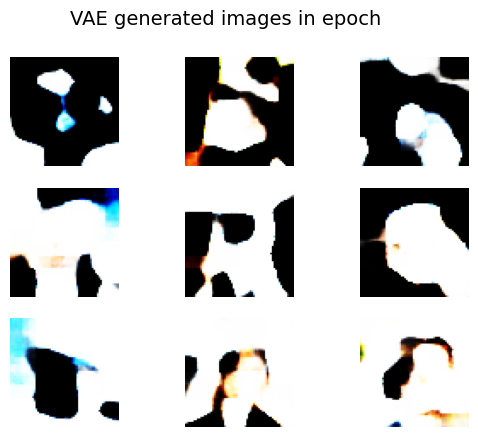

In [9]:
latent_vectors = np.random.randn(9, latent_dim)
images = decoder(latent_vectors)
grid_plot(images, epoch='', name=f'VAE generated images in epoch', n=3)

## Train on Limited Data

### First Experiment

In [ ]:
latent_dim = 32
filters = 128
encoder, decoder, vae = build_vae((64, 64, 3), latent_dim, filters=filters)

log_dir = f"{tensorboard_log_dir}/limited_vae_latent{latent_dim}_filter{filters}"
filepath = f"{model_save_path}/limited_vae_latent{latent_dim}_filter{filters}"
file_writer = tf.summary.create_file_writer(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
grid_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_vae_generation)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_freq='epoch'
)

vae.fit_generator(limited_data_generator, epochs=epochs, callbacks=[checkpoint_callback, tensorboard_callback, grid_callback])

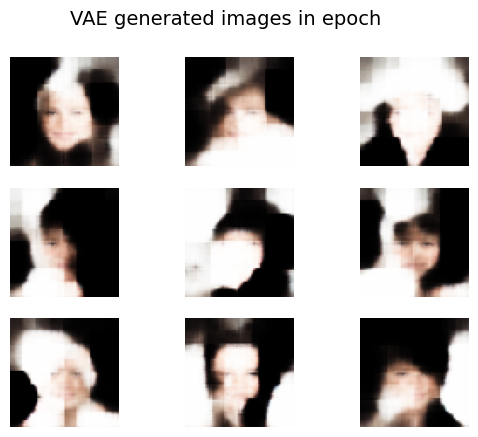

In [22]:
latent_vectors = np.random.randn(9, latent_dim)
images = decoder(latent_vectors)
grid_plot(images, epoch='', name=f'VAE generated images in epoch', n=3)

### Second Experiment

In [ ]:
latent_dim = 64
filters = 128
encoder, decoder, vae = build_vae((64, 64, 3), latent_dim, filters=filters)

log_dir = f"{tensorboard_log_dir}/limited_vae_latent{latent_dim}_filter{filters}"
filepath = f"{model_save_path}/limited_vae_latent{latent_dim}_filter{filters}"
file_writer = tf.summary.create_file_writer(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
grid_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_vae_generation)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_freq='epoch'
)

vae.fit_generator(limited_data_generator, epochs=epochs, callbacks=[checkpoint_callback, tensorboard_callback, grid_callback])

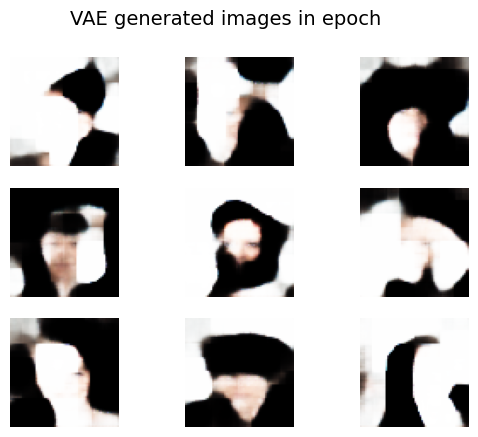

In [24]:
latent_vectors = np.random.randn(9, latent_dim)
images = decoder(latent_vectors)
grid_plot(images, epoch='', name=f'VAE generated images in epoch', n=3)

### Third Experiment

In [ ]:
latent_dim = 64
filters = 256
encoder, decoder, vae = build_vae((64, 64, 3), latent_dim, filters=filters)

log_dir = f"{tensorboard_log_dir}/limited_vae_latent{latent_dim}_filter{filters}"
filepath = f"{model_save_path}/limited_vae_latent{latent_dim}_filter{filters}"
file_writer = tf.summary.create_file_writer(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
grid_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_vae_generation)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_freq='epoch'
)

vae.fit_generator(limited_data_generator, epochs=epochs, callbacks=[checkpoint_callback, tensorboard_callback, grid_callback])

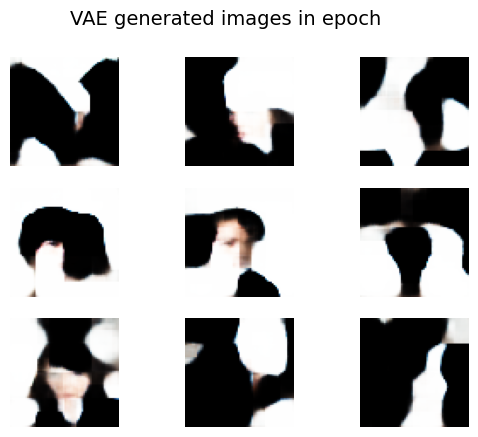

In [31]:
latent_vectors = np.random.randn(9, latent_dim)
images = decoder(latent_vectors)
grid_plot(images, epoch='', name=f'VAE generated images in epoch', n=3)

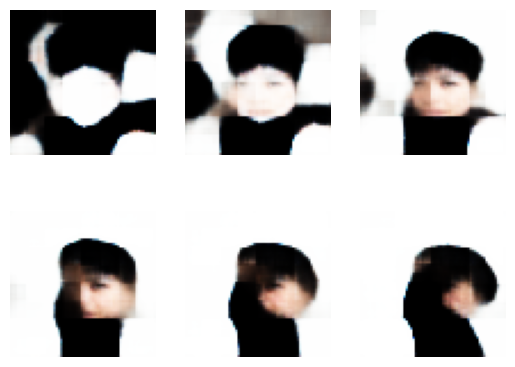

In [71]:
latent_dim = 64
interpolated_vectors = linear_interpolation(latent_dim=latent_dim, ts=[0, 0.2, 0.4, 0.6, 0.8, 1])
interpolate_images = decoder(interpolated_vectors)
n = len(interpolate_images)
for index in range(len(interpolate_images)):
    plt.subplot(2, 3, 1 + index)
    plt.axis('off')
    plt.imshow(interpolate_images[index])
fig = plt.gcf()
plt.show();

# GAN Training

In [23]:
model_save_path = "models"
tensorboard_log_dir = "logs/fit"
epochs = 20
batch_size = 128

## Train on Full Data

### First Experiment

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
data_generator = datagen.flow_from_directory(data_dir, target_size=(64, 64), batch_size=batch_size, class_mode="input")

latent_dim = 128
filters = 64
discriminator, generator, gan = build_gan((64, 64, 3), latent_dim, filters=filters)

train_gan(generator, discriminator, gan, data_generator, latent_dim, n_epochs=epochs, batch_size=batch_size)
filepath = f"{model_save_path}/gan_latent{latent_dim}_filter{filters}"
tf.saved_model.save(gan, filepath)

1/1 [==============================] - 0s 23ms/step


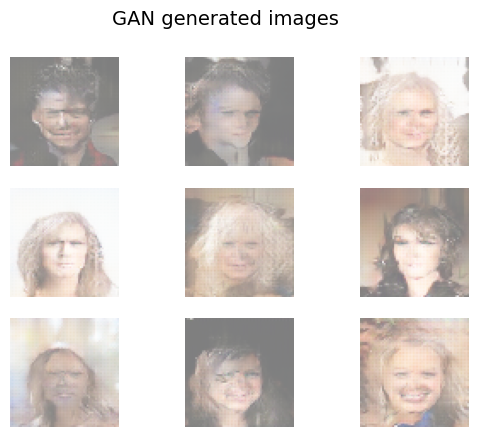

In [60]:
noise = np.random.randn(16, latent_dim)
images = generator.predict(noise)
grid_plot(images, "", name='GAN generated images', n=3, save=False, scale=True)

### Second Experiment

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
data_generator = datagen.flow_from_directory(data_dir, target_size=(64, 64), batch_size=batch_size, class_mode="input")

latent_dim = 128
filters = 128
discriminator, generator, gan = build_gan((64, 64, 3), latent_dim, filters=filters)

train_gan(generator, discriminator, gan, data_generator, latent_dim, n_epochs=epochs, batch_size=batch_size)
filepath = f"{model_save_path}/gan_latent{latent_dim}_filter{filters}"
tf.saved_model.save(gan, filepath)

1/1 [==============================] - 0s 12ms/step


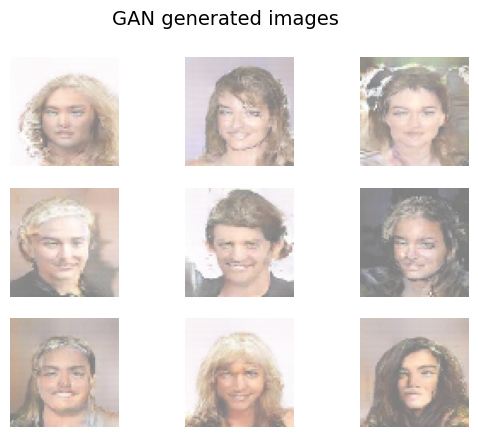

In [25]:
noise = np.random.randn(16, latent_dim)
images = generator.predict(noise)
grid_plot(images, "", name='GAN generated images', n=3, save=False, scale=True)

1/1 [==============================] - 1s 841ms/step


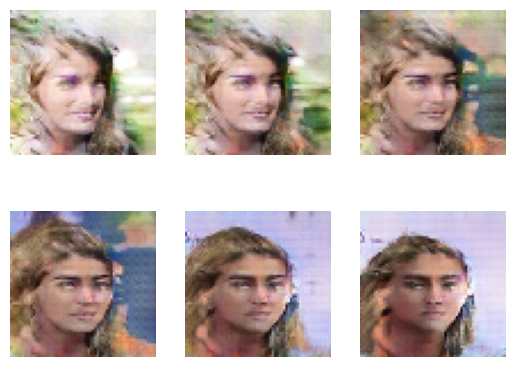

In [72]:
latent_dim = 128
interpolated_noise = linear_interpolation(latent_dim=latent_dim, ts=[0, 0.2, 0.4, 0.6, 0.8, 1])
interpolate_images = generator.predict(interpolated_noise)
n = len(interpolate_images)
for index in range(len(interpolate_images)):
    plt.subplot(2, 3, 1 + index)
    plt.axis('off')
    plt.imshow(interpolate_images[index])
fig = plt.gcf()
plt.show();